**Reading Audioset database in Tensorflow 2.0  **

This is an example based on the following tutorial https://www.tensorflow.org/tutorials/load_data/tf_records and adapted to work with the audioset database. The main difference is the use of Sequence example





In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow==2.0.0-beta1
import tensorflow as tf

import numpy as np
import IPython.display as display

     |████████████████████████████████| 87.9MB 1.2MB/s 
     |████████████████████████████████| 501kB 35.6MB/s 
     |████████████████████████████████| 3.1MB 37.1MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


Download the audioset embeddings dataset in  tf records format and the class label mappings

In [2]:
!curl -O http://storage.googleapis.com/us_audioset/youtube_corpus/v1/features/features.tar.gz
!curl -O http://storage.googleapis.com/us_audioset/youtube_corpus/v1/csv/class_labels_indices.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2468M  100 2468M    0     0  53.3M      0  0:00:46  0:00:46 --:--:-- 30.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14675  100 14675    0     0  86834      0 --:--:-- --:--:-- --:--:-- 86323


Extract the tf recods files

In [3]:
!tar xvfz features.tar.gz | wc -l

12232


Parse the csv file with the names of the labels

In [0]:
with open('class_labels_indices.csv') as f:
  idx = []
  names = []
  for line in f:
    items = line.strip("").split(',')
    idx.append(items[0])
    names.append(items[2])

labels_dict = {(i): j for i,j in zip(idx,names)}


**Read tfrecord File**

Use SequenceExample to get the audio embedding, if we use tf.train.Example we only retrieve the metadata asociated with the embedding. We should see 10 tensors of embeddings corresponding to 10 seconds of audio.

In [5]:
raw_dataset = tf.data.TFRecordDataset('audioset_v1_embeddings/bal_train/mY.tfrecord') # load example file


for raw_record in raw_dataset.take(1):
  tf_seq_example = tf.train.SequenceExample()
  tf_seq_example.ParseFromString(raw_record.numpy())
  print(tf_seq_example)

context {
  feature {
    key: "end_time_seconds"
    value {
      float_list {
        value: 50.0
      }
    }
  }
  feature {
    key: "labels"
    value {
      int64_list {
        value: 114
        value: 510
      }
    }
  }
  feature {
    key: "start_time_seconds"
    value {
      float_list {
        value: 40.0
      }
    }
  }
  feature {
    key: "video_id"
    value {
      bytes_list {
        value: "mYehsuARe6A"
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "audio_embedding"
    value {
      feature {
        bytes_list {
          value: "#\226]\006(N\223K\377\207\r\363\333\377\000Y\322v9\351\303\000\377\311\375\215E\342\377J\000\000_\000\370\222:\270\377\357\000\245\000\377\213jd\267\353\377J\033$\273\267\307\035\377\000\207\244Q\000\000\206\000\000\312\356<R\325g\303\356\016N\224\377\270\377\237\240\377\377\321\252j\357O\217\377\377,\330\000\377|\246\000\013\034\000\377\357\212\267\300b\000\000\000\251\236\000\233\035\000\326\377\327\327\377\3

In [6]:
# print raw representation of the fields
for raw_record in raw_dataset.take(1):
  print(repr(raw_record))

<tf.Tensor: id=29, shape=(), dtype=string, numpy=b'\nn\n\x1b\n\x08video_id\x12\x0f\n\r\n\x0bmYehsuARe6A\n\x1e\n\x12start_time_seconds\x12\x08\x12\x06\n\x04\x00\x00 B\n\x11\n\x06labels\x12\x07\x1a\x05\n\x03r\xfe\x03\n\x1c\n\x10end_time_seconds\x12\x08\x12\x06\n\x04\x00\x00HB\x12\xf1\n\n\xee\n\n\x0faudio_embedding\x12\xda\n\n\x86\x01\n\x83\x01\n\x80\x01#\x96]\x06(N\x93K\xff\x87\r\xf3\xdb\xff\x00Y\xd2v9\xe9\xc3\x00\xff\xc9\xfd\x8dE\xe2\xffJ\x00\x00_\x00\xf8\x92:\xb8\xff\xef\x00\xa5\x00\xff\x8bjd\xb7\xeb\xffJ\x1b$\xbb\xb7\xc7\x1d\xff\x00\x87\xa4Q\x00\x00\x86\x00\x00\xca\xee<R\xd5g\xc3\xee\x0eN\x94\xff\xb8\xff\x9f\xa0\xff\xff\xd1\xaaj\xefO\x8f\xff\xff,\xd8\x00\xff|\xa6\x00\x0b\x1c\x00\xff\xef\x8a\xb7\xc0b\x00\x00\x00\xa9\x9e\x00\x9b\x1d\x00\xd6\xff\xd7\xd7\xff\xff\x93\x009{\n\x86\x01\n\x83\x01\n\x80\x01\x1c\xaet\x004\x94\xa8M\xff\xae\x00\xdc\xd8\xfb\x01_\xcbc\xd2\xf1\xc8\x00\xf6\x9b\xba\xae\x06\xe2\xff\x00\x00\x00\x9e\x00\xff\x8c\x00\x01\xff\x90\x00\x00\x00\xff\xc7\x1c(\xff\x1a\xff\x9f\xff\

In order to parse the tensors we have to create a description of the features, note that the label field is a VarLenFeature beacuse each example is labeled with a multi-class tag without a fixed size of labels.

In [0]:
# Create a description of the features.
context = {
    'start_time_seconds': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'video_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'start_time_seconds': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'labels': tf.io.VarLenFeature(tf.int64),    
}

sequence = {
    'audio_embedding': tf.io.FixedLenSequenceFeature([], tf.string, default_value=None ,allow_missing=True)
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto, context_features=context, sequence_features=sequence)


In [0]:
parsed_dataset = raw_dataset.map(_parse_function)

Finally we can display some of the embeddings present in the tfrecords file

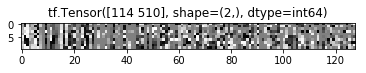

1


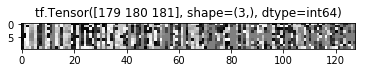

2


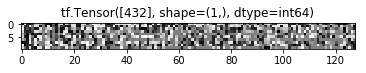

3


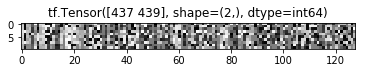

4


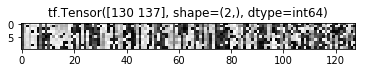

5


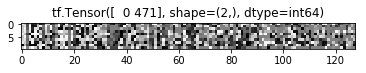

6


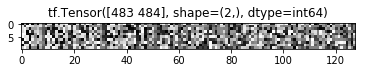

7


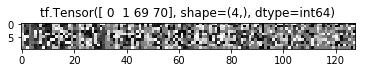

8


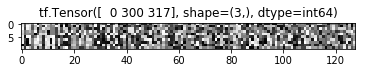

9


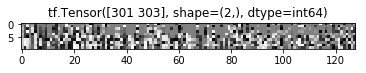

10


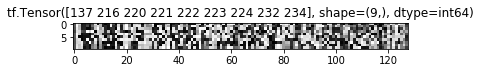

11


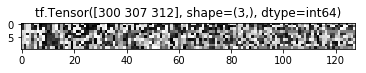

12


In [9]:
import matplotlib.pyplot as plt

count = 0
for example in parsed_dataset:
  context, sequence = example
  embedding = sequence['audio_embedding'].numpy()
  label = context['labels']
  e = tf.io.decode_raw(embedding, tf.int8)
  plt.title(label.values)
  plt.imshow(e,cmap='gray')
  plt.show()
  count+=1
  print(count)
  